In [ ]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'sarfusion'))
sys.path.append(str(Path.cwd().parent / 'sarfusion' / 'data'))

In [25]:
import lovely_tensors as lt
lt.monkey_patch()

import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

from sarfusion.models import build_model, FusionDetr
from sarfusion.data import get_dataloaders
from sarfusion.utils.general import xyxy2xywh
from sarfusion.utils.metrics import build_evaluator
from sarfusion.utils.structures import DataDict

In [ ]:
def denormalize(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return image * std + mean


def show_image_bboxes(pixel_values, labels, predictions=None):
    """
    Draw bounding boxes on an image and optionally overlay predictions.

    Args:
        pixel_values (torch.Tensor): A tensor of shape (3, H, W) representing the image.
                                     Expected to be in range [0, 1] or [0, 255].
        labels (dict): A dictionary with keys:
            - 'boxes': A tensor of shape (N, 4) representing bounding box coordinates
                       in [0, 1] range and in (x, y, h, w) format.
            - 'class_labels': A tensor of shape (N,) with class labels for each bounding box.
        predictions (dict, optional): A dictionary with keys:
            - 'boxes': A tensor of shape (M, 4) representing predicted bounding box coordinates
                       in [0, 1] range and in (x, y, h, w) format.
            - 'labels': A tensor of shape (M,) with predicted class labels.
            - 'scores': A tensor of shape (M,) with confidence scores for each predicted box.

    Returns:
        plt.Figure: A matplotlib figure object with the image and drawn bounding boxes.
    """
    import torch
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    if not isinstance(pixel_values, torch.Tensor):
        raise ValueError("pixel_values must be a torch.Tensor")
    if not isinstance(labels, dict) or 'boxes' not in labels or 'class_labels' not in labels:
        raise ValueError("labels must be a dict containing 'boxes' and 'class_labels'")

    # Convert the image tensor to a numpy array for plotting
    image = pixel_values.permute(1, 2, 0).detach().cpu().numpy()

    # Handle normalization dynamically
    if image.max() > 1:  # Likely in [0, 255] range
        image = image / 255.0  # Normalize to [0, 1] range for visualization

    boxes = labels['boxes']
    class_labels = labels['class_labels']

    if not isinstance(boxes, torch.Tensor) or boxes.shape[1] != 4:
        raise ValueError("'boxes' must be a torch.Tensor with shape (N, 4)")
    if not isinstance(class_labels, torch.Tensor) or len(class_labels) != len(boxes):
        raise ValueError("'class_labels' must be a torch.Tensor with length equal to the number of boxes")

    # Validate predictions if provided
    if predictions is not None:
        if not isinstance(predictions, dict) or \
                'boxes' not in predictions or 'labels' not in predictions or 'scores' not in predictions:
            raise ValueError(
                "predictions must be a dict containing 'boxes', 'labels', and 'scores'"
            )
        pred_boxes = predictions['boxes']
        pred_labels = predictions['labels']
        pred_scores = predictions['scores']

        if not isinstance(pred_boxes, torch.Tensor) or pred_boxes.shape[1] != 4:
            raise ValueError("'predictions[\"boxes\"]' must be a torch.Tensor with shape (M, 4)")
        if not isinstance(pred_labels, torch.Tensor) or len(pred_labels) != len(pred_boxes):
            raise ValueError("'predictions[\"labels\"]' must be a torch.Tensor with length equal to the number of boxes")
        if not isinstance(pred_scores, torch.Tensor) or len(pred_scores) != len(pred_boxes):
            raise ValueError("'predictions[\"scores\"]' must be a torch.Tensor with length equal to the number of boxes")

    # Get image dimensions
    height, width = image.shape[:2]

    # Create a matplotlib figure
    fig, ax = plt.subplots(1, figsize=(14, 14))
    ax.imshow(image)

    # Draw ground truth bounding boxes
    for box, label in zip(boxes, class_labels):
        xc, yc, w, h = box
        xmin = (xc - w / 2) * width
        ymin = (yc - h / 2) * height
        width_box = w * width
        height_box = h * height
        rect = Rectangle((xmin, ymin), width_box, height_box, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, str(label.item()), color='white', fontsize=5, 
                bbox=dict(facecolor='red', alpha=0.5, edgecolor='none'))

    # Draw predicted bounding boxes if provided
    if predictions is not None:
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            xc, yc, w, h = box
            xmin = (xc - w / 2) * width
            ymin = (yc - h / 2) * height
            width_box = w * width
            height_box = h * height
            rect = Rectangle((xmin, ymin), width_box, height_box, linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
            ax.text(
                xmin, ymin - 5, f"{label.item()} ({score.item():.2f})",
                color='white', fontsize=5, bbox=dict(facecolor='blue', alpha=0.5, edgecolor='none')
            )

    ax.axis('off')
    return fig

In [118]:
params = {
        'id2label': {
            "0": 'person'
        },
        'pretrained_path': 'checkpoints/fusiondetr_all_tepn3c4l.safetensors',
        # 'pretrained_path': 'checkpoints/fusiondetr_vis_b80foknc.safetensors',
        # 'pretrained_path': 'checkpoints/fusiondetr_ir_00aprtfc.safetensors',
        'threshold': 0.5
    }
b_params = {
    'name': 'fusiondetr',
    'params': params
}

In [89]:
# repo = "pasqualedem/RGBTFusionDetr_all_tepn3c4l"
# repo = "pasqualedem/RGBTFusionDetr_rgb_b80foknc"
repo = "pasqualedem/RGBTFusionDetr_ir_00aprtfc"

In [119]:
model = build_model(b_params)

# model = FusionDetr.from_pretrained(repo)
model.eval()

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Error loading model from checkpoints/fusiondetr_all_tepn3c4l.safetensors: trying to remove 'model.'


FusionDetr(
  (model): DetrFusionForObjectDetection(
    (model): DetrFusionModel(
      (backbone): FusionBackbone(
        (rgb_backbone): DetrConvModel(
          (conv_encoder): DetrConvEncoder(
            (model): FeatureListNet(
              (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
              (layer1): Sequential(
                (0): Bottleneck(
                  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (bn1): DetrFrozenBatchNorm2d()
                  (act1): ReLU(inplace=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): DetrFrozenBatchNorm2d()
                  (drop_block): Identity()
                  (act2): ReL

In [101]:
dataset_params = {
    "name": "wisard",
    "root": "dataset/WiSARD",
    "preprocessor": {"path": "facebook/detr-resnet-50"},
    # "folders": "vis",
    'folders': "ir",
    "single_class": True,
}

dataloader_params = {
    "batch_size": 1,
    "num_workers": 0,
}

In [102]:
(train_loader, val_loader, test_loader), deprocess = get_dataloaders(dataset_params, dataloader_params)

Using as train folders: 
 ['200929_Karen_FLIR_IR_1', '200929_Karen_FLIR_IR_2', '200929_Karen_FLIR_IR_3', '200929_Karen_FLIR_IR_4', '200929_Karen_FLIR_IR_5', '200929_Karen_FLIR_IR_6', '210327_Airfield_FLIR_IR_1', '210327_Airfield_FLIR_IR_2', '210327_Airfield_FLIR_IR_3', '210327_Airfield_FLIR_IR_4', '210327_Airfield_FLIR_IR_5', '210327_Airfield_FLIR_IR_6', '210327_Airfield_FLIR_IR_7', '210327_Airfield_FLIR_IR_8', '210924_FHL_Enterprise_IR_0402', '210924_FHL_Enterprise_IR_0406', '220109_Baker_Enterprise_IR_1']
Using as val folders: 
 ['200910_Carnation_FLIR_IR_1', '200910_Carnation_FLIR_IR_2', '200910_Carnation_FLIR_IR_3', '200910_Carnation_FLIR_IR_4', '200910_Carnation_FLIR_IR_5', '200910_Carnation_FLIR_IR_6', '200910_Carnation_FLIR_IR_7', '210924_FHL_Enterprise_IR_0135']
Using as test folders: 
 ['200704_Baker_FLIR_IR_1', '200704_Baker_FLIR_IR_2', '220109_Baker_Enterprise_IR_2', '210417_MtErie_Enterprise_IR_0004', '210417_MtErie_Enterprise_IR_0006', '210417_MtErie_Enterprise_IR_0008']


In [103]:
loader = train_loader

In [104]:
iterator = iter(loader)

In [111]:
iterations = 5
for i in range(iterations):
    batch = next(iterator)

In [112]:
batch = DataDict(**batch)

In [113]:
pixel_values = batch['pixel_values']
labels = batch['labels']
dims = batch['dims']

In [120]:
with torch.no_grad():
    outputs = model(pixel_values)

In [121]:
boxes = outputs['predictions'][0]['boxes']
# boxes = xyxy2xywh(boxes)
outputs['predictions'][0]['boxes'] = boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


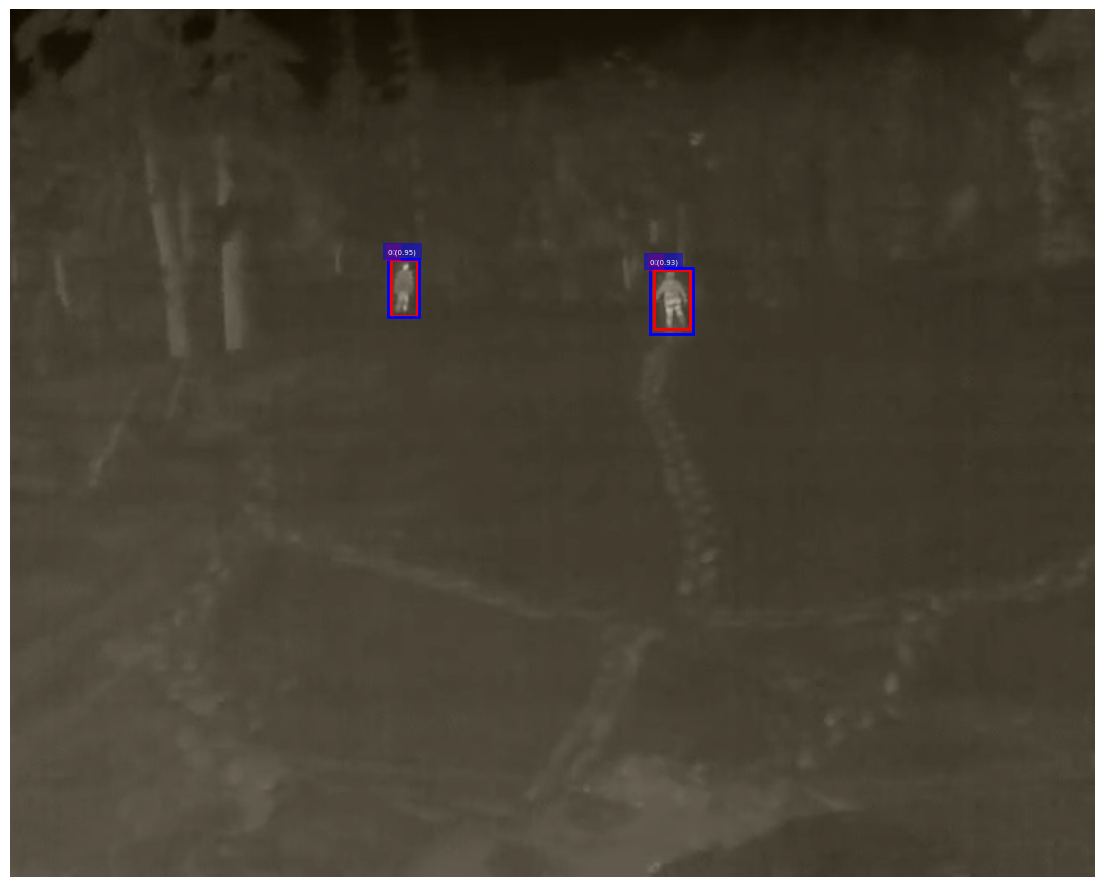

In [122]:
fig = show_image_bboxes(denormalize(pixel_values)[0], labels[0], outputs['predictions'][0])

In [117]:
model.push_to_hub(repo)

model.safetensors: 100%|██████████| 261M/261M [00:51<00:00, 5.04MB/s] 


CommitInfo(commit_url='https://huggingface.co/pasqualedem/RGBTFusionDetr_ir_00aprtfc/commit/959af300502c81ddca6de389a8e0c89036319a03', commit_message='Push model using huggingface_hub.', commit_description='', oid='959af300502c81ddca6de389a8e0c89036319a03', pr_url=None, pr_revision=None, pr_num=None)